In [1]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn

In [2]:
#===== CONSTANTS =====
DATA_PATH = '../resources/loaded.pckl'
FEATURE_PATH = '../resources/features.npy'
LABEL_PATH = '../resources/labels.npy'
RESIZE_RES = (128, 128)

In [3]:
data = pickle.load(open(DATA_PATH, 'rb'))

In [7]:
#Dataset is really unbalanced for now

dataframe = pd.DataFrame(data)
dataframe[1].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: 1, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from skimage.util import crop

data_X = []
data_y = []

for d in data:
    cropped = crop(d[0], ((0, 0), (75, 75), (0,0)), copy = False)
    resized = resize(cropped, RESIZE_RES, preserve_range=True)
    data_X.append(np.array(resized).round(decimals=0))
    data_y.append(d[1])

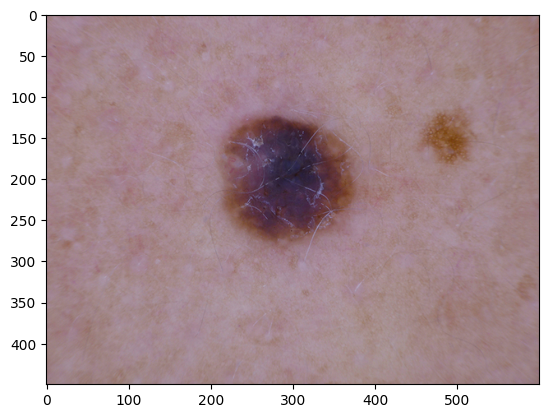

In [24]:
plt.imshow(data[54][0])

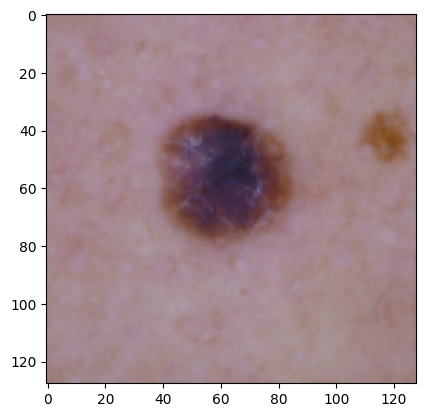

In [25]:
plt.imshow(np.array(data_X[54], dtype=np.uint32))

### Solutions to this unbalanced dataset
1. Undersampling of nv label
2. Image augumentation by rotation of bcc, akiec, vasc and df labels
3. Adding gausian blur to all labels
4. Custom class_weights

In [ ]:
#Image augumentation by rotation
from skimage.transform import rotate

to_rotate = ['bcc', 'akiec', 'vasc', 'df']
degrees_of_rotation = [90, 180, 270]

original_lenght = len(data_X)
for i in range(0, original_lenght):
    img = data_X[i]
    label = data_y[i]
    if label in to_rotate:
        for angle in degrees_of_rotation:
            data_X.append(rotate(img, angle, resize = False, preserve_range=True))
            data_y.append(label)

In [ ]:
dataframe_oversampled = pd.DataFrame(data_y)
dataframe_oversampled[0].value_counts()

In [ ]:
#Image augumentation by adding gaussian blur
from skimage.filters import gaussian

to_blur_copy = ['akiec', 'mel', 'bkl', 'vasc', 'df']

blur_nv = False
blur_bcc = False
original_lenght = len(data_X)
for i in range(0, original_lenght):
    img = data_X[i]
    label = data_y[i]
    if label in to_blur_copy:
        data_X.append(gaussian(img, sigma = 10, truncate = 1/5, preserve_range=True))
        data_y.append(label)
    else:
        if (label == 'nv'):
            if (blur_nv):
                data_X[i] = gaussian(img, sigma = 10, truncate = 1/5, preserve_range=True)
            blur_nv = not blur_nv
        else:
            if (blur_bcc):
                data_X[i] = gaussian(img, sigma = 10, truncate = 1/5, preserve_range=True)
            blur_bcc = not blur_bcc
                

In [ ]:
dataframe_oversampled = pd.DataFrame(data_y)
dataframe_oversampled[0].value_counts()

In [ ]:
#Undersampling of nv label
import random

indexes_to_remove = []
while len(indexes_to_remove) < (6705 - 2616):
    current = random.randrange(0, len(data_X))
    if (data_y[current] == 'nv' and current not in indexes_to_remove):
        indexes_to_remove.append(current)
        
indexes_to_remove.sort(reverse = True)
for i in indexes_to_remove:
    data_X.pop(i)
    data_y.pop(i)

In [ ]:
dataframe_oversampled = pd.DataFrame(data_y)
dataframe_oversampled[0].value_counts()

In [ ]:
plt.imshow(data_X[5000] / 255.0)

In [ ]:
#Encode labels and save dataset to disk
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data_X = np.array(data_X)
data_y = le.fit_transform(data_y)

In [ ]:
feature_file = open(FEATURE_PATH, 'wb')
label_file = open(LABEL_PATH, 'wb')

np.save(feature_file, data_X)
np.save(label_file, data_y)

feature_file.close()
label_file.close()

In [ ]:
le.classes_

In [ ]:
#Custom class_weights (Will need to be done with every k-fold validation iteration)
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                    classes = np.unique(data_y),
                                                    y = data_y)
class_weights.sort()
class_weights